# Plant image classification model
This notebook will cover the steps of training and infering plant type from an image.

These are the steps in this notebook:
1. Setup workspace
2. Fetching the dataset
3. Exploratory Data Analysis
4. Pre processing
5. Training, Validation and Test dataset-splits
6. Choosing a model architecture
7. Training the model
8. Validating the created model
9. Checking the accuracy of the model
10. Final testing with the test split
11. Happy inference!

## 1. Setup Workspace
The first step to work clean, is to create a clean workspace. <br/>
And download all the necessary files from pypi

Don't forget to install all the necessary dependencies from `requirements.txt` file.
using the command: `pip install -r requirements.txt`

In [12]:
import os
from enum import StrEnum
from dataclasses import dataclass

class Paths(StrEnum):
    DATA = 'data'
    OUTPUT = 'output'

@dataclass
class DatasetClass():
    relative_path: str
    count: int
    images_dims: list[tuple] = None

for folder_name in Paths:
    os.makedirs(folder_name, exist_ok=True)

DATASET_URL = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
DATASET_FILENAME = os.path.join(Paths.DATA, 'flower_photos.tgz')

## 2. Fetching the dataset
In this step we will fetch and extract the dataset to our filesystem for the following steps.

After we have created the workspace directories. We need to get some data. For that we will download the flower photos dataset from the given URL link (or you can download it manually from the tensorflow site).

In [13]:
import requests
from tqdm import tqdm

def download(url: str, filename: str) -> None:
    """
    Downloading a file and showing some indecation about the download using `tqdm`

    Args:
        `url: str` - The URL to download from the file
        `filename: str` - The path to save the downloaded file in the machine
    """
    with open(filename, 'wb') as f:
        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            total = int(r.headers.get('content-length', 0))

            # tqdm has many interesting parameters. Feel free to experiment!
            tqdm_params = {
                'desc': url,
                'total': total,
                'miniters': 1,
                'unit': 'B',
                'unit_scale': True,
                'unit_divisor': 1024,
            }
            
            with tqdm.tqdm(**tqdm_params) as progress_bar:
                for chunk in r.iter_content(chunk_size=8192):
                    progress_bar.update(len(chunk))
                    f.write(chunk)

if not os.path.exists(DATASET_FILENAME):
    download(DATASET_URL, DATASET_FILENAME)
else:
    print('The dataset file already downloaded. There is not need to try to download it again.')

The dataset file already downloaded. There is not need to try to download it again.


Exctracting the dataset from the compressed file

In [14]:
import tarfile
from tarfile import TarInfo

def extract_file(filename: str, extraction_path: str) -> None:
    """
    Extracting all the contents of tarfile

    Args:
        `filename: str` - The path to the compressed tarfile
        `extraction_path: str` - The path to the target directory which will contain the extracted contents
    """
    with tarfile.open(filename, 'r:gz') as tar:
        total_files: list[TarInfo] = tar.getmembers()

        with tqdm(total=len(total_files), unit='file', desc='Extracting') as progress_bar:
            for member in total_files:
                tar.extract(member, extraction_path)
                progress_bar.update(1)

if not os.path.exists(os.path.join(Paths.DATA, 'flower_photos')):
    extract_file(os.path.join(Paths.DATA, 'flower_photos.tgz'), Paths.DATA)
else:
    print('The dataset file already extracted. There is no need to extract it again.')

The dataset file already extracted. There is no need to extract it again.


## 3. Exploratory Data Analysis
In this step, we will plot the dataset and try to understand what it contains.

### Quantity
Checking for the available classes in our dataset and checking whether they imbalanced

Text(0, 0.5, 'Images count')

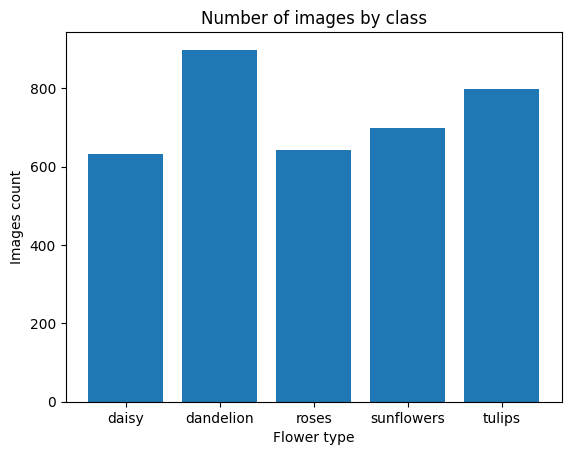

In [15]:
import matplotlib.pyplot as plt

DATASET_PARENT_PATH = os.path.join(Paths.DATA, 'flower_photos')
contents = os.listdir(DATASET_PARENT_PATH)
dataset_classes: dict[str, DatasetClass] = {}

for filename in contents:
    relative_path = os.path.join(DATASET_PARENT_PATH, filename)
    if os.path.isdir(relative_path):
        dataset_classes[filename] = DatasetClass(
            relative_path=relative_path, 
            count=len(os.listdir(relative_path))
        )

# Extracting the count of each class from the nested object
class_count: list[int] = [dataset_class.count for dataset_class in dataset_classes.values()]
NUM_OF_CLASSES: int = len(dataset_classes.keys())

# Showing the plot
plt.bar(dataset_classes.keys(), class_count)
plt.title("Number of images by class")
plt.xlabel("Flower type")
plt.ylabel("Images count")


It's seems that the `dandelion` class is bigger than the others. Let's check by how much?

In [16]:
min_class_count: int = min(class_count)
max_class_count: int = max(class_count)

print(f'The smallest class count: {min_class_count}')
print(f'The largest class count: {max_class_count}')

min_class_percent: float = (min_class_count * 100) / max_class_count
print('In percentage: ' + "{:.2f}".format(100 - min_class_percent))

The smallest class count: 633
The largest class count: 898
In percentage: 29.51


It's nearly 30 percent !

### Input layer size
Plotting the dimensions of inputs (images)

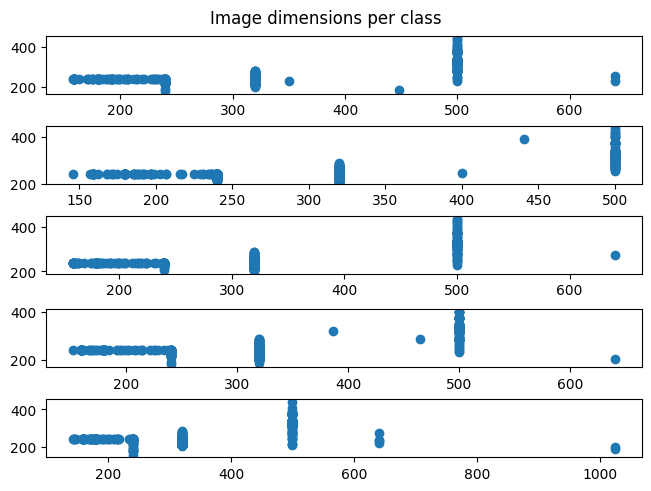

In [17]:
from PIL import Image
import numpy as np

def get_dims(file_path: str) -> tuple[int, int]:
    """
    Returns dimenstions for an RBG image

    Args:
        `file_path: str` - The path to the target image

    Returns:
        Tuple contains the width and height of the image
    """
    im = Image.open(file_path)
    arr = np.array(im)
    h,w,d = arr.shape
    return w, h


def batch_dimension_calc(folder_path: str) -> np.ndarray:
    """
    Calculating dimensions of each image in the folder

    Args:
        `folder_path: str` - The path of the folder containing the images
    """
    images_dims: list[tuple] = []

    for image_path in os.listdir(folder_path):
        image_rel_path: str = os.path.join(folder_path, image_path)
        images_dims.append(get_dims(image_rel_path))

    return np.array(images_dims)


def plot_dimensions(axis: plt, dataset_class: DatasetClass) -> None:
    """
    Plotting the dimensions of the images in a given dataclass
    
    Args:
        `axis: plt` - The axis to scatter plot in
        `dataset_class: DatasetClass` - The class of the dataset to render the scatter for
    """
    width: list = []
    height: list = []
    for dims_tuple in dataset_class.images_dims:
        width.append(dims_tuple[0])
        height.append(dims_tuple[1])

    axis.scatter(np.array(width), np.array(height))


fig, axis = plt.subplots(len(dataset_classes.keys()), constrained_layout=True)
fig.suptitle("Image dimensions per class")
current_axis: int = 0

# Calculating the dimensions of each image in each class
for class_name in dataset_classes:
    class_folder_path: str = dataset_classes[class_name].relative_path
    dataset_classes[class_name].images_dims = batch_dimension_calc(class_folder_path)
    plot_dimensions(axis[current_axis], dataset_classes[class_name])
    current_axis += 1

As this plot shows, there is no single dimensions size. Therefore we need to take this into consideration when we building the input layer of the model.

### Visualisation
So how the samples looks like?

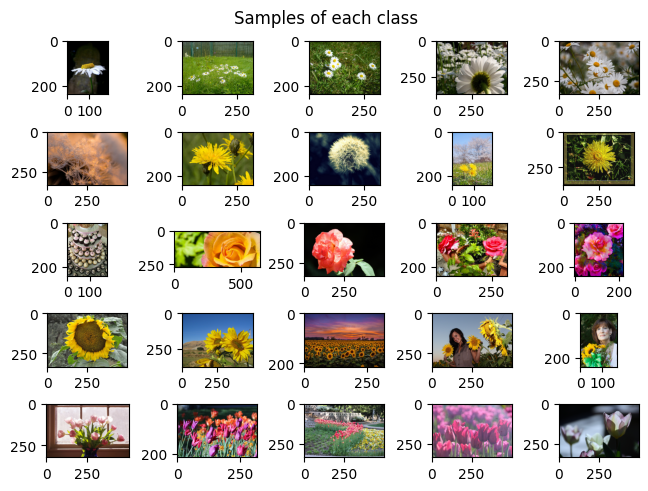

In [39]:
import random
from matplotlib.axes import Axes
from matplotlib.image import AxesImage

def generate_class_samples(selected_class: DatasetClass, num_samples: int, axes: Axes, row: int) -> list[AxesImage]:
    """
    Generating list of image subplots

    Args:
        `selected_class: DatasetClass` - The dataset class to generate images of
        `num_classes: int` - The number of image to generate
        `axes: list` - The `plt` object to draw the images over
        `row: int` - The row number to draw the images in
    """
    all_files: list[str] = os.listdir(selected_class.relative_path)
    for column in range(num_samples):
        selected_pos: int = random.randint(0, len(all_files) - 1)
        full_filename: str = os.path.join(selected_class.relative_path, all_files[selected_pos]) 
        axes[row, column].imshow(Image.open(full_filename))
        del all_files[selected_pos]


# Showing five images of each class
NUM_OF_IMAGES: int = 5
CLASSES_NAMES: list[str] = list(dataset_classes.keys())
NUM_OF_CLASSES: int = len(CLASSES_NAMES)
fig, axarr = plt.subplots(NUM_OF_CLASSES, NUM_OF_IMAGES, constrained_layout=True)
fig.suptitle("Samples of each class")
# subs: list = fig.subfigures(NUM_OF_CLASSES, 1, squeeze=False)

for row in range(NUM_OF_CLASSES):
    # subs[row, 0].suptitle(f'{CLASSES_NAMES[row]} class:')
    generate_class_samples(dataset_classes[CLASSES_NAMES[row]], NUM_OF_IMAGES, axarr, row)

We do see each class has multiple images sizes, and different compositions of the flowers inside the images. <br/> 
It's very recommended to try running this cell multiple times, because each time another images may apeer.

## 4. Pre Processing
After we concluded the EDA, we understood what data we got. We need to make it trainable. 

In order to make this data trainable, we need to actually produce numbers from those images.

How can we do that? <br/>
Actually, you can think of an image like a matrix. The dimensions of the matrix will be the number of pixels of the width and height of the image. <br/>
But, there's a problem... in those pictures, the color is meaningful, our suggested method doesn't distinguish the color each pixel has. <br/>

So how can we get over this problem?
Instead of using just a 2d matrix, we can put in each of the matrix cells instead of just a single number that represents whether the pixel is just black or white. <br/> 
We will insert an array of 3 numbers. each number represents the sub-base color of the pixel. <span style="color:red">Red</span>, <span style="color:#32de84">Green</span>, and <span style="color:#87CEFA">Blue</span>.